In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import numpy as np
ox.config(log_console=True, use_cache=True)
import matplotlib.cm as cm
import matplotlib as mpl
# ox.__version__

In [2]:
# configure the place, network type, trip times, and travel speed
place = 'Δήμος Θεσσαλονίκης'
network_type = 'walk'
dist = 6000

# download the street network
G = ox.graph_from_address(place, dist, simplify=True, network_type=network_type)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

C:\Users\owner\anaconda3\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


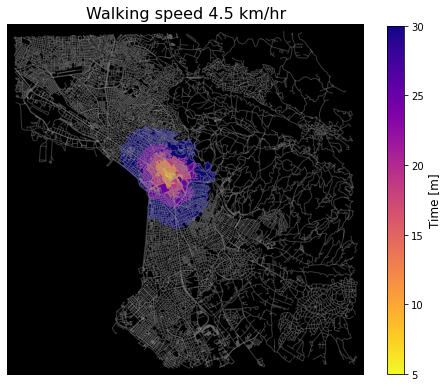

In [3]:
trip_times = np.array([1, 2, 3, 4, 6]) * 5 #in minutes
# trip_times = [15]
plt.rcParams["figure.figsize"] = (18, 10)
cmap = plt.cm.get_cmap('plasma_r')
norm=plt.Normalize(vmin=trip_times.min(), vmax = trip_times.max())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

thess = gpd.read_file('thess.json')
thess2 = gpd.GeoDataFrame(thess, geometry = 'geometry')

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

travel_speed = 4.5 # walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.8)
cb.set_label('Time [m]', fontsize = 12)

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.8, zorder=-1)
    ax.add_patch(patch)

# ax.suptitle('Isocrone Map of Thessaloniki', fontsize = 16)
ax.set_title('Walking speed {} km/hr'.format(travel_speed), fontsize = 16)
# ax.text(x[0]-1, y[0]-1, 'Just Walk')
plt.show();

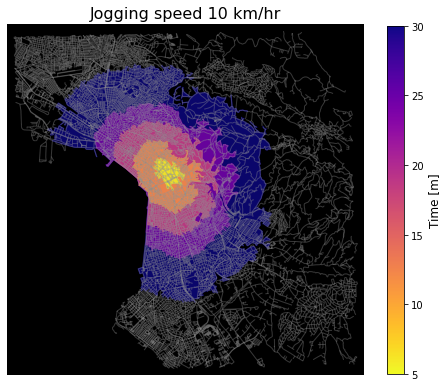

In [4]:
trip_times = np.array([1, 2, 3, 4, 6]) * 5 #in minutes
# trip_times = [15]
plt.rcParams["figure.figsize"] = (18, 10)
cmap = plt.cm.get_cmap('plasma_r')
norm=plt.Normalize(vmin=trip_times.max(), vmax = trip_times.min())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

thess = gpd.read_file('thess.json')
thess2 = gpd.GeoDataFrame(thess, geometry = 'geometry')

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

travel_speed = 10 # walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.8)
cb.set_label('Time [m]', fontsize = 12)

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.8, zorder=-1)
    ax.add_patch(patch)

# ax.suptitle('Isocrone Map of Thessaloniki', fontsize = 16)
ax.set_title('Jogging speed {} km/hr'.format(travel_speed), fontsize = 16)
# ax.text(x[0]-1, y[0]-1, 'Just Walk')
plt.show();

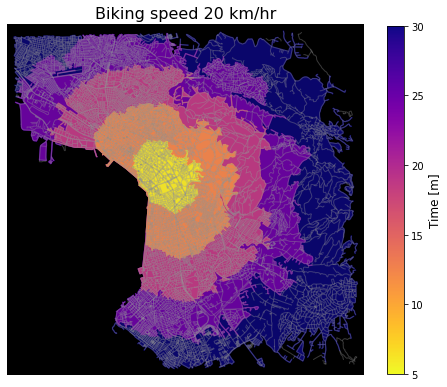

In [5]:
trip_times = np.array([1, 2, 3, 4, 6]) * 5 #in minutes
# trip_times = [15]
plt.rcParams["figure.figsize"] = (18, 10)
cmap = plt.cm.get_cmap('plasma_r')
norm=plt.Normalize(vmin=trip_times.max(), vmax = trip_times.min())
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

thess = gpd.read_file('thess.json')
thess2 = gpd.GeoDataFrame(thess, geometry = 'geometry')

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

travel_speed = 20 # walking speed in km/hour
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.8)
cb.set_label('Time [m]', fontsize = 12)

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.8, zorder=-1)
    ax.add_patch(patch)

# ax.suptitle('Isocrone Map of Thessaloniki', fontsize = 16)
ax.set_title('Biking speed {} km/hr'.format(travel_speed), fontsize = 16)
# ax.text(x[0]-1, y[0]-1, 'Just Walk')
plt.show();

In [6]:
G.graph['crs']

<Projected CRS: +proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich